# Reading files
## No need to iterate in order to optimize

In [1]:
# get train file names
import glob

train_folders = ['CAR', 'UAH', 'UJITI', 'UJIUB']

files_names = []
n_files = 0
for building in train_folders:
    cur_file_names = glob.glob('routes/' + building + '/log*')
    files_names.append(sorted(cur_file_names))
    n_files += len(cur_file_names)

print(files_names)
print('There are %d files' % n_files)

[['routes/CAR/logfile_CAR_R1_S3.txt', 'routes/CAR/logfile_CAR_R1_S3mini.txt', 'routes/CAR/logfile_CAR_R2_S3.txt', 'routes/CAR/logfile_CAR_R2_S4.txt'], ['routes/UAH/logfile_UAH_R1_S3.txt', 'routes/UAH/logfile_UAH_R1_S4.txt', 'routes/UAH/logfile_UAH_R2_S3.txt', 'routes/UAH/logfile_UAH_R2_S4.txt', 'routes/UAH/logfile_UAH_R4_S3.txt', 'routes/UAH/logfile_UAH_R4_S4.txt'], ['routes/UJITI/logfile_UJITI_R1_NEXUS5.txt', 'routes/UJITI/logfile_UJITI_R2_NEXUS5.txt'], ['routes/UJIUB/logfile_UJIUB_R1n_S3.txt', 'routes/UJIUB/logfile_UJIUB_R1r_S3.txt', 'routes/UJIUB/logfile_UJIUB_R2n_S3.txt', 'routes/UJIUB/logfile_UJIUB_R2r_S3.txt', 'routes/UJIUB/logfile_UJIUB_R3_S3.txt']]
There are 17 files


In [2]:
# import files into dataframes
import numpy as np
import pandas as pd

track= []
for building in files_names:
    track.append([])
    for track_name in building:
        print(track_name)
        track[-1].append(pd.read_csv(track_name, sep=';', engine='c', names=range(11)))
        print(np.unique(track[-1][-1][0]))

routes/CAR/logfile_CAR_R1_S3.txt
['ACCE' 'AHRS' 'GNSS' 'GYRO' 'LIGH' 'MAGN' 'POSI' 'PRES' 'SOUN' 'WIFI']
routes/CAR/logfile_CAR_R1_S3mini.txt
['ACCE' 'AHRS' 'GNSS' 'GYRO' 'MAGN' 'POSI' 'SOUN' 'WIFI']
routes/CAR/logfile_CAR_R2_S3.txt
['ACCE' 'AHRS' 'GNSS' 'GYRO' 'LIGH' 'MAGN' 'POSI' 'PRES' 'PROX' 'SOUN'
 'WIFI']
routes/CAR/logfile_CAR_R2_S4.txt
['ACCE' 'AHRS' 'GNSS' 'GYRO' 'HUMI' 'LIGH' 'MAGN' 'POSI' 'PRES' 'PROX'
 'SOUN' 'TEMP' 'WIFI']
routes/UAH/logfile_UAH_R1_S3.txt
['ACCE' 'AHRS' 'GNSS' 'GYRO' 'LIGH' 'MAGN' 'POSI' 'PRES' 'SOUN' 'WIFI']
routes/UAH/logfile_UAH_R1_S4.txt
['ACCE' 'AHRS' 'GNSS' 'GYRO' 'HUMI' 'LIGH' 'MAGN' 'POSI' 'PRES' 'SOUN'
 'TEMP' 'WIFI']
routes/UAH/logfile_UAH_R2_S3.txt
['ACCE' 'AHRS' 'GNSS' 'GYRO' 'LIGH' 'MAGN' 'POSI' 'PRES' 'SOUN' 'WIFI']
routes/UAH/logfile_UAH_R2_S4.txt
['ACCE' 'AHRS' 'GNSS' 'GYRO' 'HUMI' 'LIGH' 'MAGN' 'POSI' 'PRES' 'SOUN'
 'TEMP' 'WIFI']
routes/UAH/logfile_UAH_R4_S3.txt
['ACCE' 'AHRS' 'GNSS' 'GYRO' 'LIGH' 'MAGN' 'POSI' 'PRES' 'SOUN' 'WIFI']
route

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Find time limits per POSI id
def posi_time_limits(pos_array):
    # create start and end index time array
    pos_array['ind_begin_time'] = np.zeros((pos_array.shape[0]))
    pos_array['ind_end_time'] = np.zeros((pos_array.shape[0]))
    pos_array['ind_end_time'].iat[-1] = 99999

    for i in range(1, pos_array.shape[0]):
        cur_split = (float(pos_array['Time'].iloc[i]) + float(pos_array['Time'].iloc[i-1])) / 2
        pos_array['ind_begin_time'].iat[i] = cur_split       
        pos_array['ind_end_time'].iat[i-1] = cur_split       
    return pos_array

# create true ground dataframes
pos = []
for i in range(len(track)):
    pos.append([])
    for j in range(len(track[i])):
        pos[i].append(track[i][j][[1, 2, 3, 4, 5, 6, 7]].iloc[track[i][j][0].values == 'POSI'])
        pos[i][j] = pos[i][j].dropna(axis=1)
        pos[i][j].columns = ['Time', 'index', 'Lat', 'Lon', 'FloorID', 'BuildingID']
        pos[i][j] = posi_time_limits(pos[i][j])


In [4]:
# associate signals with POSI ids. Spliting at middle of the time between POSI measurements using posi_time_limits
for i in range(len(track)):
    for j in range(len(track[i])):
        track[i][j]['POSI_floor'] = np.zeros((track[i][j].shape[0])) * np.nan
        track[i][j]['POSI_building'] = np.zeros((track[i][j].shape[0])) * np.nan
        for k in range(pos[i][j].shape[0]):
            ind_begin_time = pos[i][j]['ind_begin_time'].iloc[k]
            ind_end_time = pos[i][j]['ind_end_time'].iloc[k]
    
            ind = pos[i][j]['index'].iloc[k]
            ind_floor = pos[i][j]['FloorID'].iloc[k]
            ind_building = pos[i][j]['BuildingID'].iloc[k]
            
            index_limits = np.logical_and(track[i][j][1].values >= ind_begin_time, 
                                          track[i][j][1].values < ind_end_time)
            
            track[i][j]['POSI_floor'].iloc[index_limits] = ind_floor
            track[i][j]['POSI_building'].iloc[index_limits] = ind_building

print(track[i][j].head())

      0      1       2         3        4         5        6        7  \
0  GYRO  0.018  89.931   0.58521  0.41692  -0.74526  3.00000      NaN   
1  AHRS  0.019  89.931   36.8048   5.5949 -32.75710  0.31558 -0.04448   
2  LIGH  0.020  89.940    2124.0        0       NaN      NaN      NaN   
3  ACCE  0.020  89.941  -1.38864  6.10043   7.44118  3.00000      NaN   
4  GYRO  0.031  89.951  -0.48686  0.38546   0.01344  3.00000      NaN   

         8     9  10  POSI_floor  POSI_building  
0      NaN   NaN NaN         0.0           30.0  
1 -0.25246 -43.0 NaN         0.0           30.0  
2      NaN   NaN NaN         0.0           30.0  
3      NaN   NaN NaN         0.0           30.0  
4      NaN   NaN NaN         0.0           30.0  


/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
# Pad ground truth in order to use interpolation later
for i in range(len(track)):
    for j in range(len(track[i])):
        pos_pad_start = pos[i][j].iloc[0]
        pos_pad_start.at['Time'] = 0
        pos_pad_end = pos[i][j].iloc[-1]
        pos_pad_end.at['Time'] = track[i][j][1].values[-1]
        pos_array = np.vstack((pos_pad_start.values.reshape((1, pos[i][j].shape[1])), 
                                pos[i][j].values, 
                                pos_pad_end.values.reshape((1, pos[i][j].shape[1]))))
        pos[i][j] = pd.DataFrame(pos_array, columns=pos[i][j].columns.values)

i = 1
j = 2
print(files_names[i][j])
print(pos[i][j].shape[0])
print(pos[i][j]['FloorID'].values)
print(pos[i][j].head())

routes/UAH/logfile_UAH_R2_S3.txt
66
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 3.0 3.0
 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0
 3.0 3.0 3.0 2.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
     Time index          Lat       Lon FloorID BuildingID ind_begin_time  \
0       0     1  40.51278407  -3.34849       0         20              0   
1   8.618     1  40.51278407  -3.34849       0         20              0   
2  34.656     2  40.51296307  -3.34844       0         20         21.637   
3  51.802     3  40.51296539  -3.34859       0         20         43.229   
4  67.263     4  40.51302711  -3.34866       0         20        59.5325   

  ind_end_time  
0       21.637  
1       21.637  
2       43.229  
3      59.5325  
4      74.8175  


In [6]:
# Interpolate sensors' time
import scipy.interpolate as interpolate

for i in range(len(track)):
    for j in range(len(track[i])):
        interp_ground_truth_lat = interpolate.interp1d(pos[i][j]['Time'].astype(float), pos[i][j]['Lat'])
        track[i][j]['interp_lat'] = interp_ground_truth_lat(track[i][j][1])
        interp_ground_truth_lon = interpolate.interp1d(pos[i][j]['Time'].astype(float), pos[i][j]['Lon'])
        track[i][j]['interp_lon'] = interp_ground_truth_lon(track[i][j][1])
print(track[0][0].head())

      0      1         2         3          4          5        6       7  \
0  ACCE  0.094  4292.788  -1.38864    4.62560    8.40844  3.00000     NaN   
1  MAGN  0.095  4292.788  -5.64000  -39.72000  -19.56000  3.00000     NaN   
2  GYRO  0.097  4292.792  -0.16432   -0.20861   -0.19609  3.00000     NaN   
3  AHRS  0.098  4292.792   28.5264     9.6349 -161.85360  0.11909 -0.2296   
4  LIGH  0.098  4292.792   14561.0          3        NaN      NaN     NaN   

        8    9  10  POSI_floor  POSI_building  interp_lat  interp_lon  
0     NaN  NaN NaN         0.0           10.0   40.313471    -3.48315  
1     NaN  NaN NaN         0.0           10.0   40.313471    -3.48315  
2     NaN  NaN NaN         0.0           10.0   40.313471    -3.48315  
3 -0.9504  3.0 NaN         0.0           10.0   40.313471    -3.48315  
4     NaN  NaN NaN         0.0           10.0   40.313471    -3.48315  


In [7]:
# Create wifi data frames
wifi = []
for i in range(len(track)):
    wifi.append([])
    for j in range(len(track[i])):
        wifi[-1].append(track[i][j][[1, 4, 5, 'POSI_floor', 'POSI_building', 'interp_lat',  
                                    'interp_lon']].iloc[track[i][j][0].values == 'WIFI'])
        wifi[-1][-1].columns = ['AppTime', 'MAC', 'rssi', 'POSI_floor', 'POSI_building', 'interp_lat', 'interp_lon']
print(wifi[0][0].head())

     AppTime                MAC  rssi  POSI_floor  POSI_building  interp_lat  \
637    2.293  00:0b:86:27:36:c2 -82.0         0.0           10.0   40.313471   
638    2.293  00:0b:86:27:32:e0 -66.0         0.0           10.0   40.313471   
639    2.293  00:0b:86:27:32:e2 -66.0         0.0           10.0   40.313471   
640    2.293  00:0b:86:27:32:e1 -68.0         0.0           10.0   40.313471   
641    2.293  00:0b:86:27:36:c0 -82.0         0.0           10.0   40.313471   

     interp_lon  
637    -3.48315  
638    -3.48315  
639    -3.48315  
640    -3.48315  
641    -3.48315  


In [8]:
"""MAC counting"""
def get_mac_structure(routes, test_route):
    # Only for the train data
    # create list of mac addresses for all the samples
    total_macs = []
    for i in range(len(wifi)):
        for j in range(len(wifi[i])):
            if routes[i][j] != test_route:
                track_mac_array = wifi[i][j]['MAC'].values
                for mac_add in track_mac_array:
                    if not mac_add in total_macs:
                        total_macs.append(mac_add)
                        
    # create list of mac addresses for each building
    building_macs = {10: [], 20: [], 30: [], 40: []}
    for i in range(len(wifi)):
        for j in range(len(wifi[i])):
            if routes[i][j] != test_route:
                track_mac_array = wifi[i][j]
                for k in range(track_mac_array.shape[0]):
                    mac_line = track_mac_array.iloc[k]
                    mac = mac_line['MAC']
                    build = int(mac_line['POSI_building'])
                    if not mac in building_macs[build]:
                        building_macs[build].append(mac)

    # create list of mac addresses for each building for each floor
    floor_macs = {10: [[], [], [], [], [], []], 20: [[], [], [], [], [], []], 
                  30: [[], [], [], [], [], []], 40: [[], [], [], [], [], []]}
    for i in range(len(wifi)):
        for j in range(len(wifi[i])):
            if routes[i][j] != test_route:
                track_mac_array = wifi[i][j]
                for k in range(track_mac_array.shape[0]):
                    mac_line = track_mac_array.iloc[k]
                    mac = mac_line['MAC']
                    build = int(mac_line['POSI_building'])
                    floor = int(mac_line['POSI_floor'])
                    if not mac in floor_macs[build][floor]:
                        floor_macs[build][floor].append(mac)
                        
#     # print mac statistics
#     if DEBUG:
#         print('total macs')
#         print(len(total_macs))
#         print('building macs')
#         for build in sorted(building_macs):
#             print(build, len(building_macs[build]), ',')
#         print('floor macs')
#         for build in sorted(floor_macs):
#             for j in range(len(floor_macs[build])):
#                 print(build, j, len(floor_macs[build][j]), ',')
    return [total_macs, building_macs, floor_macs]

In [9]:
"""WiFi functions"""
# Make WiFi data into global dummy variable
def dummify_wifi(wifi_df, wifi_list):
    wifi_samples = np.unique(wifi_df['AppTime'].values)
    wifi_dummy = np.ones((wifi_samples.shape[0], len(wifi_list))) * -200
    wifi_dummy = pd.DataFrame(wifi_dummy, columns=wifi_list, index=wifi_samples)
    for i, sample_time in enumerate(wifi_samples):
            wifi_cur = wifi_df.iloc[wifi_df['AppTime'].values == sample_time]
            for j in range(wifi_cur.shape[0]):
                if str(wifi_cur['MAC'].iat[j]) in wifi_list:
                    wifi_dummy[wifi_cur['MAC'].iat[j]].iat[i] = wifi_cur['rssi'].iat[j]
    wifi_dummy = normalize_wifi(wifi_dummy)
    wifi_dummy = add_results_wifi(wifi_dummy, wifi_df)
    return wifi_dummy

# Normalize wifi and cut noise
def normalize_wifi(wifi_dummy_df):
    max_per_line = np.amax(wifi_dummy_df, axis=1)
    wifi_dummy_df.iloc[:, :] = wifi_dummy_df.values - max_per_line.reshape((max_per_line.shape[0], 1))
    return wifi_dummy_df

# Add ground truth columnns to the wifi dataframe
def add_results_wifi(df, results_df):
    df['POSI_building'] = np.ones((df.shape[0],))
    df['POSI_floor'] = np.ones((df.shape[0],))
    df['interp_lat'] = np.ones((df.shape[0],))
    df['interp_lon'] = np.ones((df.shape[0],))
    wifi_samples = df.index.values
    for i, sample_time in enumerate(wifi_samples):
        results_cur = results_df.iloc[results_df['AppTime'].values == sample_time]
        for j in range(results_cur.shape[0]):
            df['POSI_building'].iat[i] = results_cur['POSI_building'].iat[0]
            df['POSI_floor'].iat[i] = results_cur['POSI_floor'].iat[0]
            df['interp_lat'].iat[i] = results_cur['interp_lat'].iat[0]
            df['interp_lon'].iat[i] = results_cur['interp_lon'].iat[0]
    return df

# Make WiFi data into dummy variable with the buildingIDs as values. 
# In each row the number of MACs associated with the buildingID is the value
def dummify_wifi_building(wifi_df, wifi_building_list):
    wifi_samples = np.unique(wifi_df['AppTime'].values)
    wifi_dummy = np.zeros((wifi_samples.shape[0], len(wifi_building_list)))
    wifi_dummy = pd.DataFrame(wifi_dummy, columns=list(wifi_building_list.keys()), index=wifi_samples)
    for i, sample_time in enumerate(wifi_samples):
            wifi_cur = wifi_df.iloc[wifi_df['AppTime'].values == sample_time]
            for j in range(wifi_cur.shape[0]):
                for k in wifi_building_list:
                    if str(wifi_cur['MAC'].iat[j]) in wifi_building_list[k]:
                        wifi_dummy[k].iat[i] += 1
    wifi_dummy = add_results_wifi(wifi_dummy, wifi_df)
    return wifi_dummy

# Make WiFi data into dummy variable with the floorIDs as values. 
def dummify_wifi_floor(wifi_df, wifi_floor_list):
    wifi_samples = np.unique(wifi_df['AppTime'].values)
    wifi_dummy = np.zeros((wifi_samples.shape[0], len(wifi_floor_list[10])))
    wifi_dummy = pd.DataFrame(wifi_dummy, index=wifi_samples)
    for i, sample_time in enumerate(wifi_samples):
            wifi_cur = wifi_df.iloc[wifi_df['AppTime'].values == sample_time]
            for j in range(wifi_cur.shape[0]):
                for build in wifi_floor_list:
                    for l in range(len(wifi_floor_list[build])):
                        if str(wifi_cur['MAC'].iat[j]) in wifi_floor_list[build][l]:
                            wifi_dummy[l].iat[i] += 1
    wifi_dummy = add_results_wifi(wifi_dummy, wifi_df)
    return wifi_dummy

# level noise when packets have lower power than it
def wifi_level_noise(wifi_dummy_df, noise):
    if len(wifi_dummy_df.shape) > 1:
        noise_not = (wifi_dummy_df.values >= noise) * 1
        wifi_dummy_df.iloc[:, :] = noise_not * wifi_dummy_df.values + (1- noise_not) * noise
    else:
        noise_not = (wifi_dummy_df.values >= noise) * 1
        wifi_dummy_df.iloc[:] = noise_not * wifi_dummy_df.values + (1- noise_not) * noise
    return wifi_dummy_df

In [10]:
"""Grid class"""
# Change measurement from meters to differnial earth angle
def mtod_calc(local_latitude, mes_m):
    local_radius = 6378137 * np.cos(np.pi * local_latitude / 180)
    mes_d = 360 * mes_m / (local_radius * 2 * np.pi)
    return mes_d

# Calculate errors
def dtom_calc(local_latitude, mes_d):
    local_radius = 6378137 * np.cos(np.pi * local_latitude / 180)
    mes_m = mes_d * (local_radius * 2 * np.pi) / 360
    return mes_m

# Create the grid for fingerprinting
class GridTrain:
    def __init__(self, lat_samples, lon_samples, resolution_m, rssis, translate, classifier):
        self.lat_lim = (np.min(lat_samples), np.max(lat_samples))
        self.lon_lim = (np.min(lon_samples), np.max(lon_samples))
        self.lat_loc = np.median(lat_samples)
        self.resolution = mtod_calc(self.lat_loc, resolution_m)
        self.lat_grid_start = self.lat_lim[0] + mtod_calc(self.lat_loc, translate[0])
        self.lon_grid_start = self.lon_lim[0] + mtod_calc(self.lat_loc, translate[1])
        self.grid_lat = np.arange(self.lat_grid_start, self.lat_lim[1], self.resolution)
        self.grid_lon = np.arange(self.lon_grid_start, self.lon_lim[1], self.resolution)
        self.grid_rssis, self.grid_cell_id, self.grid_dict = self.fit_rssis_to_grid(lat_samples, lon_samples, rssis)
        self.classifier = classifier
        self.classifier.fit(self.grid_rssis.values, self.grid_cell_id)
        
    # Allocate packets to a cell
    def fit_rssis_to_grid(self, lat_samples, lon_samples, rssis):
        rssis_noise_lim = wifi_level_noise(rssis, -25)
        grid_rssis = []
        grid_cell_id = []
        grid_dict = {}
        cur_cell_id = 0
        for i in range(self.grid_lat.shape[0]):
            for j in range(self.grid_lon.shape[0]):
                inside_lat = np.logical_and(lat_samples >= self.grid_lat[i], 
                                            lat_samples < (self.grid_lat[i] + self.resolution))
                inside_lon = np.logical_and(lon_samples >= self.grid_lon[j], 
                                            lon_samples < (self.grid_lon[j] + self.resolution))
                inside_cell = np.logical_and(inside_lat, inside_lon)
                if np.sum(inside_cell):
                    grid_rssis.append(rssis.iloc[inside_cell])
                    grid_cell_id.append(np.repeat(cur_cell_id, np.sum(inside_cell)))
                    grid_dict[cur_cell_id] = [self.grid_lat[i] + 0.5 * self.resolution, 
                                              self.grid_lon[j] + 0.5 * self.resolution]
                    cur_cell_id += 1
        grid_cell_id = np.hstack(tuple(grid_cell_id))
        grid_rssis = pd.concat(grid_rssis, axis=0)
        return(grid_rssis, grid_cell_id, grid_dict)
    
    # Predict from classifier
    def predict_classifier(self, testset):
        self.classifier.predict(testset)


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# print an image of the predicitions
def show_prediction(results, predictions):
    # Plot 2D predicitions
    plt.figure(1, figsize=(15, 15))
    plt.subplot(421)
    plt.plot(results.index.values, results['Lat'].values, 'r',
             predictions.index.values, predictions['Lat'].values, 'bo')
    plt.title('Lat(t): Route - red; WiFi fingerprinting - blue')
    plt.subplot(422)
    plt.plot(results.index.values, results['Lon'].values, 'r',
             predictions.index.values, predictions['Lon'].values, 'bo')
    plt.title('Lng(t): Route - red; WiFi fingerprinting - blue')
    plt.subplot(423)
    plt.plot(results.index.values, results['FloorID'].values, 'r',
             predictions.index.values, predictions['FloorID'].values, 'bo')
    plt.title('FloorID: Route - red; WiFi fingerprinting - blue')
    plt.subplot(424)
    plt.plot(results.index.values, results['BuildingID'].values, 'r',
             predictions.index.values, predictions['BuildingID'].values, 'bo')
    plt.title('FloorID: Route - red; WiFi fingerprinting - blue')
    plt.show()

In [36]:
# Smooth signal 
"""need to add trend"""
def exp_smooth(time_series, sensor_series, alpha, trend):
    # forward in time
    sensor_forward = np.zeros((sensor_series.shape))
    sensor_forward[0] = sensor_series[0]
    sensor_trend = 0
    for i in range(1, time_series.shape[0]):
        dt = time_series[i] - time_series[i-1]
        adj_alpha = dt * alpha
        adj_trend = dt * trend
        sensor_forward[i] = adj_alpha * sensor_series[i] + (1 - adj_alpha) * (sensor_forward[i-1] + sensor_trend)
        sensor_trend = adj_trend * (sensor_forward[i] - sensor_forward[i-1]) + (1 - adj_trend) * sensor_trend
    # backwards in time
    sensor_backwards = np.zeros((sensor_series.shape))
    sensor_trend = 0
    sensor_backwards[-1] = sensor_series[-1]
    for i in range(time_series.shape[0]-2, -1, -1):
        dt = time_series[i+1] - time_series[i]
        adj_alpha = dt * alpha
        adj_trend = dt * trend
        sensor_backwards[i] = adj_alpha * sensor_series[i] + (1 - adj_alpha) * (sensor_backwards[i+1] + sensor_trend) 
        sensor_trend = adj_trend * (sensor_backwards[i] - sensor_backwards[i+1]) + (1 - adj_trend) * sensor_trend
    sensor_smoothed = (sensor_forward + sensor_backwards) / 2
#     plt.plot(time_series, sensor_series, 'r',
#              time_series, sensor_forward, 'go',
#              time_series, sensor_backwards, 'bo',
#              time_series, sensor_smoothed, 'ko',
#             )
#     plt.show()
    return sensor_smoothed

In [13]:
# Interpolate wifi to tested time stamps
def int_wifi_to_sub(time_samples, pred):
    test_sub_pred = pd.DataFrame(np.zeros((time_samples.shape[0], 4)), index=time_samples, 
                                 columns=['Lat', 'Lon', 'FloorID', 'BuildingID'])
    # Pad sensors' samples
    latlon_pad_start = pred[['Lat', 'Lon']].iloc[0]
    latlon_pad_end = pred[['Lat', 'Lon']].iloc[-1]
    latlon_array = np.vstack((latlon_pad_start, 
                              pred[['Lat', 'Lon']].values, 
                              latlon_pad_end))
    floor_pad_start = pred['FloorID'].iloc[0]
    floor_pad_end = pred['FloorID'].iloc[-1]
    floor_array = np.hstack((floor_pad_start, 
                             pred['FloorID'].values, 
                             floor_pad_end))
    building_pad_start = pred['BuildingID'].iloc[0]
    building_pad_end = pred['BuildingID'].iloc[-1]
    building_array = np.hstack((building_pad_start, 
                               pred['BuildingID'].values, 
                               building_pad_end))
    time_pad_start = 0
    time_pad_end = time_samples[-1]
    time_array = np.hstack((time_pad_start, 
                            pred.index.values, 
                            time_pad_end))
    
    # Interpolate sensors' samples
    interp_pred_wifi_lat = interpolate.interp1d(time_array, latlon_array[:, 0])
    interp_pred_wifi_lon = interpolate.interp1d(time_array, latlon_array[:, 1])
    interp_pred_wifi_floor = interpolate.interp1d(time_array, floor_array)
    interp_pred_wifi_building = interpolate.interp1d(time_array, building_array)
    test_sub_pred['Lat'] = interp_pred_wifi_lat(test_sub_pred.index.values)
    test_sub_pred['Lon'] = interp_pred_wifi_lon(test_sub_pred.index.values)
    test_sub_pred['FloorID'] = interp_pred_wifi_floor(test_sub_pred.index.values)
    test_sub_pred['BuildingID'] = interp_pred_wifi_building(test_sub_pred.index.values)
    test_sub_pred['FloorID'] = (test_sub_pred['FloorID'].values + 0.5).astype(int)
    
    return test_sub_pred

def int_gps_to_sub(time_samples, pred):
    test_sub_pred = pd.DataFrame(np.zeros((time_samples.shape[0], 2)), index=time_samples, 
                                 columns=['Lat', 'Lon', 'GPS_accuracy'])
    # Pad GPS samples
    lat_pad_start = pred['GPS_lat'].iloc[0]
    lat_pad_end = pred['GPS_lat'].iloc[-1]
    lat_array = np.hstack((lat_pad_start, pred['GPS_lat'].values, lat_pad_end))
    
    lon_pad_start = pred['GPS_lon'].iloc[0]
    lon_pad_end = pred['GPS_lon'].iloc[-1]
    lon_array = np.hstack((lon_pad_start, pred['GPS_lon'].values, lon_pad_end))
    
    acc_pad_start = pred['GPS_accuracy'].iloc[0]
    acc_pad_end = pred['GPS_accuracy'].iloc[-1]
    acc_array = np.hstack((acc_pad_start, pred['GPS_accuracy'].values, acc_pad_end))
    
    time_pad_start = 0
    time_pad_end = time_samples[-1]
    time_array = np.hstack((time_pad_start, 
                            pred.index.values, 
                            time_pad_end))
    
    # Interpolate sensors' samples
    interp_pred_gps_lat = interpolate.interp1d(time_array, lat_array)
    interp_pred_gps_lon = interpolate.interp1d(time_array, lon_array)
    interp_pred_gps_acc = interpolate.interp1d(time_array, acc_array)
    test_sub_pred['Lat'] = interp_pred_gps_lat(test_sub_pred.index.values)
    test_sub_pred['Lon'] = interp_pred_gps_lon(test_sub_pred.index.values)
    test_sub_pred['GPS_accuracy'] = interp_pred_gps_acc(test_sub_pred.index.values)
    

In [14]:
# Error calculation and evaluation function
def calc_errors(targets, predictions, dtom, debug):
    error_2d = np.sqrt((predictions['Lat'].values - targets['Lat'].values) ** 2 +
                       (predictions['Lon'].values - targets['Lon'].values) ** 2) * dtom
    error_build = 50 * (predictions['BuildingID'].values != targets['BuildingID'].values)
    error_floor = 15 * np.abs(predictions['FloorID'].values - targets['FloorID'].values)
    test_errors = error_2d + error_floor + error_build
    
    test_errors = np.sort(test_errors)
    density = 1 / test_errors.shape[0]
    error_cum_prob = [density]
    error_ranked = [test_errors[0]]
    for err_i in test_errors[1:]:
        error_cum_prob.append(error_cum_prob[-1] + density)
        error_ranked.append(err_i)
    test_error_q3 = (test_errors[int(test_errors.shape[0] * 3 / 4)])
    print('The q3 error is %.3f' % test_error_q3)
    if debug:
        # Plot commulative error of predicitions
        plt.figure(1, figsize=(10, 10))
        plt.plot(error_cum_prob, error_ranked, 'r')
        plt.title('Cumulative error')
        plt.show()

In [15]:
# plot debug info
DEBUG = True
# false if using real test data
EVAL = True

# split to different tracks in order to not overfit while testing
ROUTES = [[0, 0, 1, 1], [2, 2, 3, 3, 4, 4], [5, 6], [7, 7, 8, 8, 9]]
TEST_ROUTES = [9]
INTERVAL = 0.5

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import ParameterGrid

param_grid = {
          'building_alpha': [0.001],
          'building_trend': [0.001],
          'floor_alpha': [0.1],
          'floor_trend': [0.1],
          'floor_noise': [{10: -10, 20: -10, 30: -10, 40: -10}], 
          'floor_n': [200],
          'floor_depth': [{10: 1, 20: 5, 30: 5, 40: 5}],
          'floor_features': [{10: 1.0, 20: 1.0, 30: 1.0, 40: 1.0}],
          'grid_noise': [{10: -25, 20: -25, 30: -25, 40: -25}],
          'gps_aid': [False],
          'cell_size': [10],
          'grid_alpha': [0.2],
          'grid_trend': [0.2]
         }

# Iterations for optimization

{'grid_trend': 0.2, 'floor_alpha': 0.1, 'cell_size': 10, 'floor_trend': 0.1, 'floor_noise': {40: -10, 10: -10, 20: -10, 30: -10}, 'floor_features': {40: 1.0, 10: 1.0, 20: 1.0, 30: 1.0}, 'grid_noise': {40: -25, 10: -25, 20: -25, 30: -25}, 'floor_n': 200, 'grid_alpha': 0.2, 'floor_depth': {40: 5, 10: 1, 20: 5, 30: 5}, 'building_alpha': 0.001, 'gps_aid': False, 'building_trend': 0.001}
For test route 9
Creating dummy WiFi dataframes
Creating training datasets
Training RF
Creating test datasets
Prediciting test results


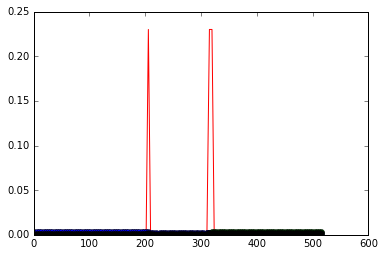

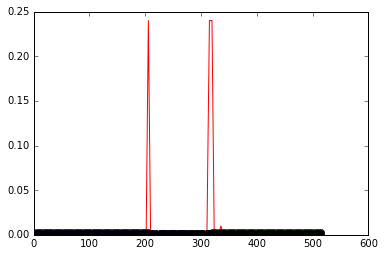

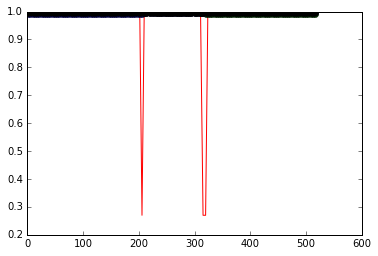

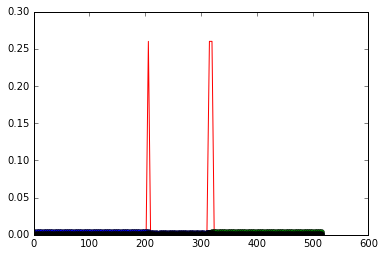


 Test BuildingID probabality #0 1.0


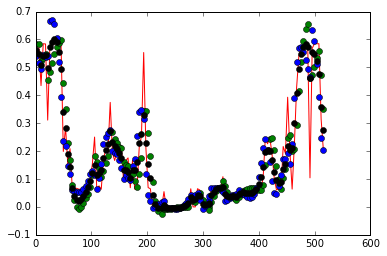

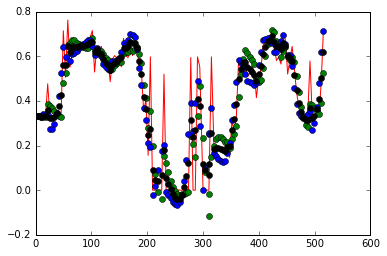

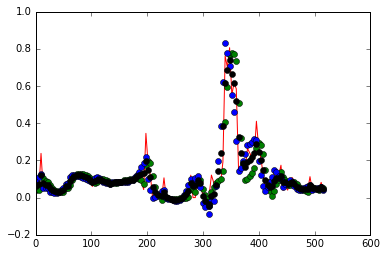

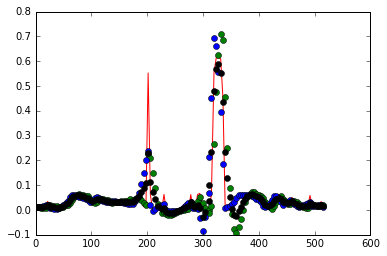

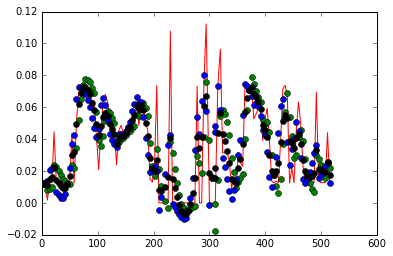

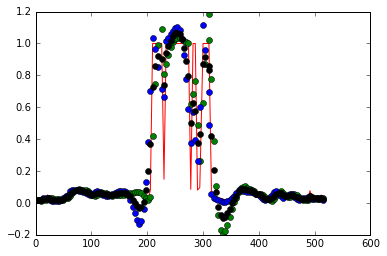

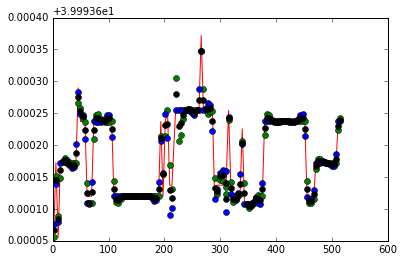

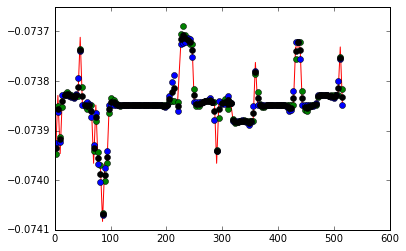

Creating GPS files
0


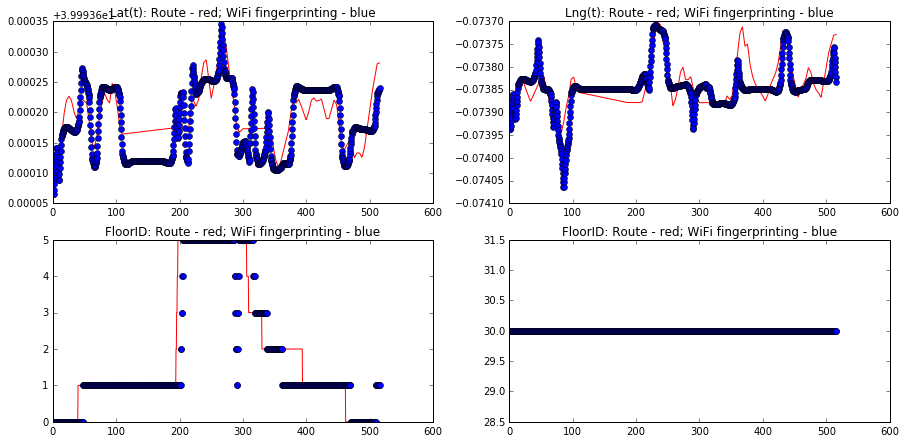

The q3 error is 5.452


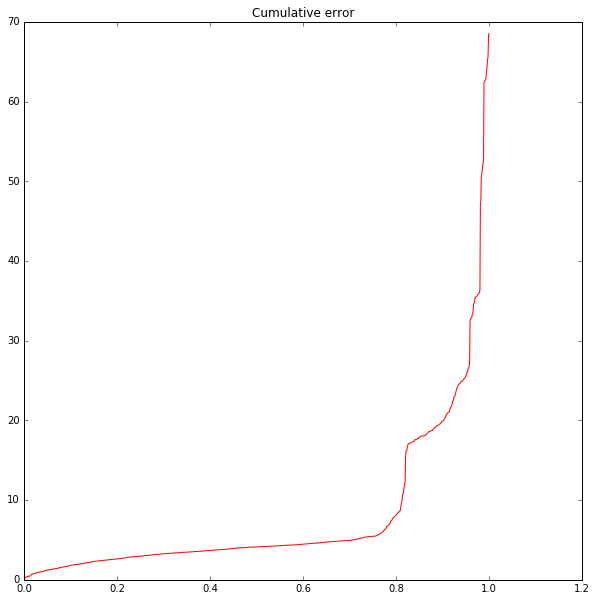

In [39]:
"""Doesn't work with building change"""

for params in ParameterGrid(param_grid):
    print(params)
    for cur_test_route in TEST_ROUTES:
        print('For test route %d' % cur_test_route)
        # Create macs database
        total_macs, building_macs, floor_macs = get_mac_structure(ROUTES, cur_test_route)

        # Restarting variables
        wifi_dummy_building = []
        wifi_dummy_floor = []
        wifi_dummy_total = []

        train_build = []
        train_wifi = []
        train_floor = {10: 0, 20: 0, 30: 0, 40: 0}
        train_floor_results = {10: 0, 20: 0, 30: 0, 40: 0}
        train_2d = {10: [[], [], [], [], [], []], 20: [[], [], [], [], [], []], 
                    30: [[], [], [], [], [], []], 40: [[], [], [], [], [], []]}
        train_2d_lat = {10: [[], [], [], [], [], []], 20: [[], [], [], [], [], []], 
                        30: [[], [], [], [], [], []], 40: [[], [], [], [], [], []]}
        train_2d_lon = {10: [[], [], [], [], [], []], 20: [[], [], [], [], [], []], 
                        30: [[], [], [], [], [], []], 40: [[], [], [], [], [], []]}
        train_2d_grid_results = {10: [[], [], [], [], [], []], 20: [[], [], [], [], [], []], 
                                 30: [[], [], [], [], [], []], 40: [[], [], [], [], [], []]}
        
        rfc_floor = {10: 0, 20: 0, 30: 0, 40: 0}

        train_2d_grid = {10: [[], [], [], [], [], []], 20: [[], [], [], [], [], []], 
                        30: [[], [], [], [], [], []], 40: [[], [], [], [], [], []]}
        train_2d_grid_results = {10: [[], [], [], [], [], []], 20: [[], [], [], [], [], []], 
                                 30: [[], [], [], [], [], []], 40: [[], [], [], [], [], []]}
        
        test_wifi = []
        test_build = []
        test_wifi_results = []

        predicted_build = []
        predicted_build_proba = []
        predicted_build_proba_smoothed = []
        predicted_build_smoothed = []
        
        predicted_floor = []
        predicted_floor_proba = []
        predicted_floor_smoothed = []
        predicted_floor_proba_smoothed = []
        
        predicted_cell = []
        predicted_2d = []
        
        test_predictions = []
        
        test_deg_m_scale = []

        test_sub_timestamps = []        
        test_sub_results = [] 
        test_sub_predicitions = [] 

        gps = []
        test_gps = []

        eval_errors = []
        
        """Converting WiFi into dummy variables"""
        print('Creating dummy WiFi dataframes')
        # Create building wifi dummy variable
        for i in range(len(wifi)):
            wifi_dummy_building.append([])
            for j in range(len(wifi[i])):
                wifi_dummy_building[i].append(dummify_wifi_building(wifi[i][j], building_macs))

        """Need to add to the floor train and test files"""
        # Create floor wifi dummy variable
        for i in range(len(wifi)):
            wifi_dummy_floor.append([])
            for j in range(len(wifi[i])):
                wifi_dummy_floor[i].append(dummify_wifi_floor(wifi[i][j], floor_macs))

        
        # Create wifi dummy variable
        for i in range(len(wifi)):
            wifi_dummy_total.append([])
            for j in range(len(wifi[i])):
                wifi_dummy_total[i].append(dummify_wifi(wifi[i][j], total_macs))

        """Train data"""
        print('Creating training datasets')
        # Create building train
        for i in range(len(wifi_dummy_total)):
            for j in range(len(wifi_dummy_total[i])):
                if ROUTES[i][j] != cur_test_route:
                    train_build.append(wifi_dummy_building[i][j])
        train_build = pd.concat(train_build, axis=0)
        train_build_results = train_build['POSI_building']
        train_build = train_build[[10, 20, 30, 40]]

        # Create wifi train file
        for i in range(len(wifi_dummy_total)):
            for j in range(len(wifi_dummy_total[i])):
                if ROUTES[i][j] != cur_test_route:
                    train_wifi.append(wifi_dummy_total[i][j])
        train_wifi = pd.concat(train_wifi, axis=0)    

        # Create floor train
        for building in train_floor:
            train_floor[building] = train_wifi.iloc[train_build_results.values == building][building_macs[building]]
            train_floor[building] = wifi_level_noise(train_floor[building], -10)
            train_floor_results[building] = train_wifi.iloc[train_build_results.values == building]['POSI_floor']
        
        # Create 2D train
        for i in range(len(wifi_dummy_total)):
            for j in range(len(wifi_dummy_total[i])):
                if ROUTES[i][j] != cur_test_route:
                    track_mac_array = wifi_dummy_total[i][j]
                    for k in range(track_mac_array.shape[0]):
                        mac_line = track_mac_array.iloc[k]
                        build = int(mac_line['POSI_building'])
                        floor = int(mac_line['POSI_floor'])
                        lat = float(mac_line['interp_lat'])
                        lon = float(mac_line['interp_lon'])
                        train_2d[build][floor].append(mac_line[floor_macs[build][floor]].values.reshape((1, len(floor_macs[build][floor]))))
                        train_2d_lat[build][floor].append(lat)
                        train_2d_lon[build][floor].append(lon)

        # Concat samples inside each floor
        for build in train_2d:
            for floor in range(len(train_2d[build])):
                if len(train_2d[build][floor]):
                    train_2d[build][floor] = np.vstack(tuple(train_2d[build][floor]))
                    train_2d[build][floor] = pd.DataFrame(train_2d[build][floor], columns=floor_macs[build][floor])
        
        """Train ML"""
        print('Training RF')
        # Train building
        rfc_build = RandomForestClassifier(n_estimators=100, max_depth=4 ,max_features=1, random_state=2016)
        rfc_build.fit(train_build.values, train_build_results.values)

        # Train floor
        for building in rfc_floor:
            rfc_floor[building] = RandomForestClassifier(n_estimators=params['floor_n'], 
                                                         max_depth=params['floor_depth'][building], 
                                                         max_features=params['floor_features'][building], 
                                                         random_state=2016)
            rfc_floor[building].fit(train_floor[building].values, train_floor_results[building].values)
            
        # Train grid
        for build in train_2d:
            for floor in range(len(train_2d[build])):
                if len(train_2d[build][floor]):
                    train_2d_grid[build][floor] = GridTrain(train_2d_lat[build][floor], 
                                                            train_2d_lon[build][floor], params['cell_size'], 
                                                            train_2d[build][floor], (-0.5 * params['cell_size'], 
                                                                                     -0.5 * params['cell_size']),
                                                            RandomForestClassifier(n_estimators=200, max_depth=20,
                                                                                   max_features=0.5, random_state=2016))
        """Test data"""
        print('Creating test datasets')
        if EVAL:
            # Create test answers dataframe
            for i in range(len(wifi_dummy_building)):
                for j in range(len(wifi_dummy_building[i])):
                    if ROUTES[i][j] == cur_test_route:
                        test_wifi_results.append(pd.DataFrame(np.zeros((wifi_dummy_building[i][j].shape[0], 4)), 
                                                              index=wifi_dummy_building[i][j].index.values, 
                                                              columns=['Lat', 'Lon', 'FloorID', 'BuildingID']))
                        test_wifi_results[-1]['Lat'] = wifi_dummy_total[i][j]['interp_lat'].values.astype(float)
                        test_wifi_results[-1]['Lon'] = wifi_dummy_total[i][j]['interp_lon'].values.astype(float)
                        test_wifi_results[-1]['FloorID'] = wifi_dummy_total[i][j]['POSI_floor'].values
                        test_wifi_results[-1]['BuildingID'] = wifi_dummy_total[i][j]['POSI_building'].values

        # Create building test
        for i in range(len(wifi_dummy_building)):
            for j in range(len(wifi_dummy_building[i])):
                if ROUTES[i][j] == cur_test_route:
                    test_build.append(wifi_dummy_building[i][j][[10, 20, 30, 40]])

        # Create wifi test file
        for i in range(len(wifi_dummy_total)):
            for j in range(len(wifi_dummy_total[i])):
                if ROUTES[i][j] == cur_test_route:
                    test_wifi.append(wifi_dummy_total[i][j])

        """Predict test data, need to add smoothing"""
        print('Prediciting test results')

        # Create test predictions dataframe
        for i in range(len(wifi_dummy_building)):
            for j in range(len(wifi_dummy_building[i])):
                if ROUTES[i][j] == cur_test_route:
                    test_predictions.append(pd.DataFrame(np.zeros((wifi_dummy_building[i][j].shape[0], 4)), 
                                                         index=wifi_dummy_building[i][j].index.values, 
                                                         columns=['Lat', 'Lon', 'FloorID', 'BuildingID']))

        # Predict buildingID
        for i in range(len(test_build)):
            predicted_build.append(rfc_build.predict(test_build[i].values))
            predicted_build_proba.append(rfc_build.predict_proba(test_build[i].values))
            # Smooth probabilities
            predicted_build_proba_smoothed.append(np.zeros(predicted_build_proba[i].shape))
            predicted_build_smoothed.append(np.zeros(predicted_build_proba[i].shape[0], ))
            for j in range(predicted_build_proba[i].shape[1]):
                predicted_build_proba_smoothed[i][:, j] = exp_smooth(test_build[i].index.values, 
                                                                     predicted_build_proba[i][:, j], 
                                                                     params['building_alpha'], 
                                                                     params['building_trend'])
            # Smoothed result
            predicted_max = np.argmax(predicted_build_proba_smoothed[i], axis=1)
            for j in range(predicted_max.shape[0]):
                predicted_build_smoothed[i][j] = rfc_build.classes_[predicted_max[i]] 
            test_predictions[i]['BuildingID'] = predicted_build_smoothed[i]
            if EVAL and DEBUG:
                print('\n', 'Test BuildingID probabality #%d' %i, 
                      np.sum(test_predictions[i]['BuildingID'].values == test_wifi_results[i]['BuildingID'].values) / 
                      test_wifi_results[i].shape[0])
            
        # Predict floorID
        for test_i in range(len(test_wifi)):
            predicted_floor.append([])
            predicted_floor_proba.append([])
            
            for row_i in range(test_wifi[test_i].shape[0]):
                cur_pred_build = test_predictions[test_i]['BuildingID'].iloc[row_i]
                cur_measurement = test_wifi[test_i][building_macs[cur_pred_build]].iloc[row_i]
                cur_measurement = wifi_level_noise(cur_measurement, 
                                                   params['floor_noise'][test_predictions[test_i]['BuildingID'].iloc[row_i]])
                predicted_floor[test_i].append(int(rfc_floor[cur_pred_build].predict([cur_measurement.values])))
                predicted_floor_proba[test_i].append(rfc_floor[cur_pred_build].predict_proba([cur_measurement.values])[0])
            predicted_floor_proba[test_i] = np.array(predicted_floor_proba[test_i])
            # Smooth probabilities                                            
            predicted_floor_proba_smoothed.append(np.zeros(predicted_floor_proba[test_i].shape))
            predicted_floor_smoothed.append(np.zeros(predicted_floor_proba[test_i].shape[0], ))
            for j in range(predicted_floor_proba[test_i].shape[1]):
                predicted_floor_proba_smoothed[test_i][:, j] = exp_smooth(test_wifi[test_i].index.values, 
                                                                          predicted_floor_proba[test_i][:, j],
                                                                          params['floor_alpha'], params['floor_trend'])
            # Smoothed result
            predicted_max = np.argmax(predicted_floor_proba_smoothed[test_i], axis=1)
            for j in range(predicted_max.shape[0]):
                predicted_floor_smoothed[test_i][j] = rfc_floor[cur_pred_build].classes_[predicted_max[j]]
            test_predictions[test_i]['FloorID'] = predicted_floor_smoothed[test_i]
 
        # Predict 2Dgrid
        for test_i in range(len(test_wifi)):
            predicted_cell.append([])
            predicted_2d.append([])
            for row_i in range(test_wifi[test_i].shape[0]):
                cur_pred_build = int(test_predictions[test_i]['BuildingID'].iloc[row_i])
                cur_pred_floor = int(test_predictions[test_i]['FloorID'].iloc[row_i])
                cur_measurement = test_wifi[test_i][floor_macs[cur_pred_build][cur_pred_floor]].iloc[row_i]
                cur_measurement = wifi_level_noise(cur_measurement, params['grid_noise'][cur_pred_build])
                cur_prediction = int(train_2d_grid[cur_pred_build][cur_pred_floor].classifier.predict([cur_measurement.values]))
                predicted_cell[test_i].append(cur_prediction)
                predicted_2d[test_i].append(train_2d_grid[cur_pred_build][cur_pred_floor].grid_dict[cur_prediction])
            predicted_2d[test_i] = np.array(predicted_2d[test_i])
            test_predictions[test_i]['Lat'] = exp_smooth(test_wifi[test_i].index.values, 
                                                         predicted_2d[test_i][:, 0],
                                                         params['grid_alpha'], params['grid_trend'])
            test_predictions[test_i]['Lon'] = exp_smooth(test_wifi[test_i].index.values, 
                                                         predicted_2d[test_i][:, 1],
                                                         params['grid_alpha'], params['grid_trend'])
        
        """GPS prediction"""
        print('Creating GPS files')
        if params['gps_aid']:
            for i in range(len(track)):
                gps.append([])
                for j in range(len(track[i])):
                    gps[-1].append(track[i][j][[1, 3, 4, 5, 6, 7, 8, 9, 10, 'POSI_floor', 'POSI_building', 'interp_lat',
                                                'interp_lon']].iloc[track[i][j][0].values == 'GNSS'])
                    gps[-1][-1].columns = ['AppTime', 'GPS_lat', 'GPS_lon', 'GPS_alt', 'GPS_bearing', 'GPS_accuracy', 
                                           'GPS_speed', 'GPS_sat_viewed', 'GPS_sat_used', 'POSI_floor', 'POSI_building', 
                                           'interp_lat', 'interp_lon']
                    gps[-1][-1].index = gps[-1][-1]['AppTime'].values
                    gps[-1][-1] = gps[-1][-1].drop(['AppTime'], axis=1)
                    if ROUTES[i][j] == cur_test_route:
                        test_gps.append(gps[i][j])
        
        """Interpolate to wanted time stamps"""
        # Create a test answer with 0.5 seconds intervals
        test_i = 0
        for i in range(len(track)):
            for j in range(len(track[i])):
                if ROUTES[i][j] == cur_test_route:
                    last_sample_time = track[i][j][1].iloc[-1]
                    test_sub_timestamps.append(np.arange(0, last_sample_time, INTERVAL))
                    test_sub_predicitions.append(int_wifi_to_sub(test_sub_timestamps[-1], test_predictions[test_i]))
                    if EVAL:
                        test_sub_results.append(int_wifi_to_sub(test_sub_timestamps[-1], test_wifi_results[test_i]))
                    test_i += 1
                    
        """Plot predicitons"""
        if EVAL and DEBUG:
            for i in range(len(test_build)):
                print(i)
                show_prediction(test_sub_results[i], test_sub_predicitions[i])

        """Evaluate errors"""
        if EVAL:
            for i in range(len(test_build)):
                test_deg_m_scale.append(dtom_calc(np.median(test_sub_predicitions[i]['Lat'].values), 1))
                calc_errors(test_sub_results[i], test_sub_predicitions[i], test_deg_m_scale[i], DEBUG)
                
        """Write to file"""
        if not EVAL:
            for i in range(len(test_build)):
                np.savetxt('try1_file%d.csv' % i, test_sub_predicitions[i].values, fmt='%.1f %.8f %.8f %d %d', delimiter=',')
        print('')